## Metis ML Classification Project

Chaya Wurman

Goal: Given the CDC NHANES (National Health and Nutrition Examination Survey) data,
can we predict if a patient has had a stroke. Strokes are caused by many medical and
lifestyle factors, and knowing which factors are highly correlated with strokes can
help better predict those who are at higher risk and help mitigate the risk before
a potential life-threatening event happens.

This notebook contains the final models for trees & scoring for our goal!

In [1]:
# Import all our necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load all the data
data = pd.read_csv("data_feature_engineered.csv")
# drop the first col from the csv
data = data.iloc[: , 1:]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5583 entries, 0 to 5582
Data columns (total 20 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   chest_pain                                  5583 non-null   float64
 1   high_blood_pressure_diagnosed               5583 non-null   float64
 2   high_blood_cholesterol                      5583 non-null   float64
 3   overweight_diagnosed                        5583 non-null   float64
 4   coronary_heart_disease                      5583 non-null   float64
 5   LABEL_had_stroke                            5583 non-null   float64
 6   diabetes_diagnosed                          5583 non-null   float64
 7   diabetes_high_blood_sugar_but_not_diabetes  5583 non-null   float64
 8   smoking_smoked_at_least_100_cigarettes      5583 non-null   float64
 9   income_family_monthly                       5583 non-null   float64
 10  alcohol_use_

In [23]:
# Trees will require our data to be label encoded

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
data["marital_status"] = encoder.fit_transform(data["marital_status"])
data["race"] = encoder.fit_transform(data["race"])

In [24]:
# Split data into train and test
from sklearn.model_selection import train_test_split

X = data.loc[:, data.columns != "LABEL_had_stroke"]
y = data.LABEL_had_stroke

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)



In [25]:
# Use SMOTENC since we have categorical and
from imblearn.over_sampling import SMOTENC

categorial_indices = [0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 13, 14, 15, 18]
smote_nc = SMOTENC(categorical_features=categorial_indices, random_state=0)
X_train, y_train = smote_nc.fit_resample(X_train, y_train)


In [43]:
from xgboost import XGBClassifier
xgboost_model = XGBClassifier(max_depth=1, n_estimators=70)
xgboost_model.fit(X_train, y_train)

# from sklearn.metrics import f1_score, recall_score
# for n_estimators in range(10, 200, 20):
#     model = XGBClassifier(max_depth=1, n_estimators=n_estimators)
#     model.fit(X_train, y_train)
#     predictions = model.predict(X_test)
#     print(n_estimators, f1_score(y_test, predictions), recall_score(y_test, predictions))


[00:04:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chaya.wurman/miniconda3/envs/metis/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=1, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=70, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [44]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(max_depth=6, n_estimators=200)
random_forest_model.fit(X_train, y_train)

# I edited this code block to do some super rough tuning of our hyperparameters to optimize
# for recall and f1_score
# from sklearn.metrics import f1_score, recall_score
#
# for max_depth in range(1, 10):
#     random_forest_model = RandomForestClassifier(max_depth=max_depth, n_estimators=200)
#     random_forest_model.fit(X_train, y_train)
#     predictions = random_forest_model.predict(X_test)
#     print(f1_score(y_test, predictions), recall_score(y_test, predictions))

RandomForestClassifier(max_depth=6, n_estimators=200)

Metrics for XGBoost
  - Accuracy: 0.8290062667860341
  - Recall: 0.6097560975609756
  - Precision: 0.125
  - AUC: 0.7235583461782574
Metrics for Random Forest
  - Accuracy: 0.8137869292748433
  - Recall: 0.4634146341463415
  - Precision: 0.09268292682926829
  - AUC: 0.6452760903073714


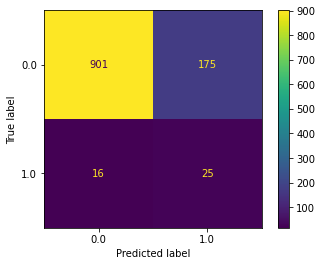

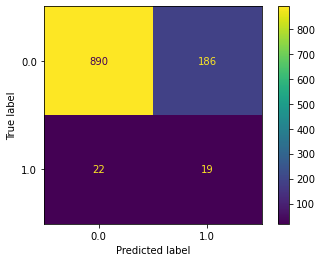

In [47]:
from sklearn.metrics import recall_score, accuracy_score, precision_score, roc_curve, auc, f1_score

# Get hard predictions
xg_boost_predictions = xgboost_model.predict(X_test)

random_forest_predictions = random_forest_model.predict(X_test)

# Basic: accurary, recall, precision
def print_basic_metrics(model_name, y_true, y_pred):
    print(f"Metrics for {model_name}")
    print(f"  - Accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"  - Recall: {recall_score(y_true, y_pred)}")
    print(f"  - Precision: {precision_score(y_true, y_pred)}")
    print(f"  - F1 Score: {f1_score(y_true, y_pred)}")
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
    print(f"  - AUC: {auc(fpr, tpr)}")


print_basic_metrics("XGBoost", y_test, xg_boost_predictions)
print_basic_metrics("Random Forest", y_test, random_forest_predictions)

# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(xgboost_model, X_test, y_test)
ConfusionMatrixDisplay.from_estimator(random_forest_model, X_test, y_test)
